# Importing Libraries

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Transfer Learning/Classification with transfer learning')

In [0]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np

import pets

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)


#  Cats Vs Dogs Dataset

In [3]:
pets.download_and_extract('data','.')

In [4]:
class_to_index = {'cat':0, 'dog':1}
index_to_class = {0:'cat',1:'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Number of training examples:', count_train)
print('Number of test examples:', count_test)

#train_annot

Number of training examples: 3680
Number of test examples: 3669


# Get Random Batch

In [0]:
image_dir = 'data/images/'

def get_random_batch(annot,batch_size =4):
  all_keys =list(annot.keys())
  total_exampels = len(all_keys)

  indices = np.random.choice(range(total_exampels),batch_size)

  x = np.zeros((batch_size, 128, 128, 3))
  y = np.zeros((batch_size , 1))
  images =  []

  for i, index in enumerate(indices):
    image_path = os.path.join(image_dir, all_keys[index])
    image = tf.keras.preprocessing.image.load_img(
        image_path , target_size = (128,128)
    )
    arr = tf.keras.preprocessing.image.img_to_array(image)
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
    arr = np.expand_dims(arr, axis = 0)
    x[i] = arr
    y[i] = class_to_index[annot[all_keys[index]]]
    images.append(image)

  return x,y,images




Displaying first 8 examples..


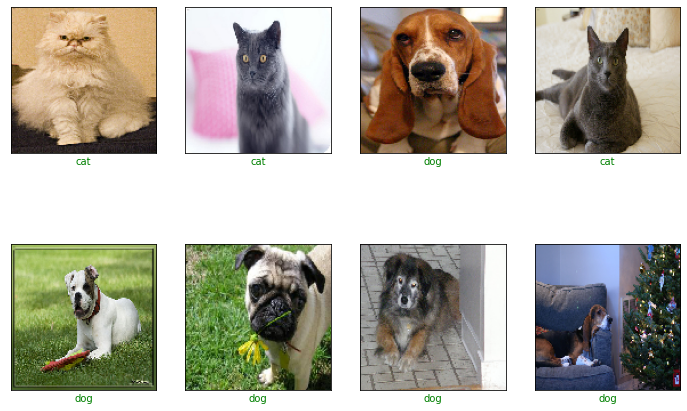

In [6]:
x, y, images = get_random_batch(train_annot,batch_size = 8)
pets.display_examples(x,y,y,images,index_to_class).show()

#  Create Model

In [7]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False, input_shape =  (128,128,3), pooling = 'avg',weights = 'imagenet'
)
mnet.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
________________

In [8]:
def create_model():
  model = tf.keras.models.Sequential([
         mnet,
         tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(1,activation = 'sigmoid')                            
  ])
  model.layers[0].trainable = False
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model 

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Task5 : Model Training

In [0]:
def data_generator(batch_size,annot):
  while True:
    x,y,_ = get_random_batch(annot,batch_size )
    yield(x,y)


In [10]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)

print('Training steps:', steps_per_epoch)
print('Validation steps:',validation_steps)

Training steps: 115
Validation steps: 114


In [11]:
%%time

_ = model.fit_generator(
    data_generator(batch_size,train_annot),
    validation_data =data_generator(batch_size,test_annot),
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs = 1
)

Instructions for updating:
Please use Model.fit, which supports generators.
115/115 [==============================] - 39s 341ms/step - loss: 0.2588 - accuracy: 0.8957 - val_loss: 0.0989 - val_accuracy: 0.9731
CPU times: user 46.1 s, sys: 1.66 s, total: 47.7 s
Wall time: 48.6 s


# Task6 : Predictions

In [0]:
x,y,images = get_random_batch(test_annot, batch_size = 8)
preds = model.predict(x) 

Displaying first 8 examples..


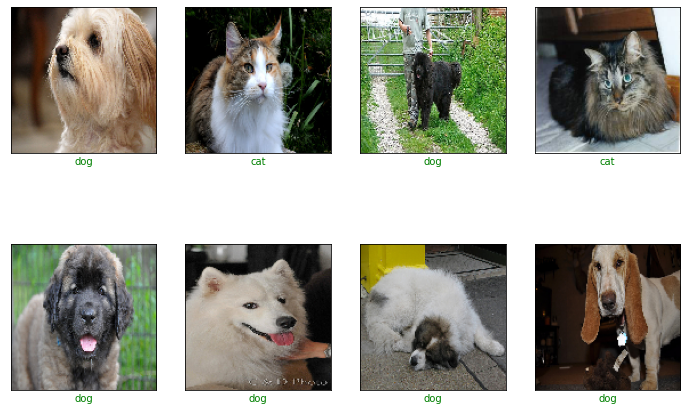

In [15]:
pets.display_examples(x,y,preds,images,index_to_class).show()